# Imports

In [1]:
# imports
import numpy as np
import torch
from tueplots import bundles, figsizes
import wandb
import matplotlib.pyplot as plt

import sys

%load_ext autoreload
%autoreload 2

sys.path.insert(0, '.')

In [77]:
from analysis import sweep2df, learning_stats,corrected_jacobian_stats, RED, BLUE


In [3]:
plt.rcParams.update(bundles.neurips2022(usetex=True))
plt.rcParams.update({
    'text.latex.preamble': [r'\usepackage{amsfonts}', # mathbb
                            r'\usepackage{amsmath}'] # boldsymbol
})

/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/_collections_abc.py:834: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [4]:
# Constants
ENTITY = "causal-representation-learning"
PROJECT = "nl-causal-representations"

# W&B API
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

# Data loading

## 3D SEM

In [5]:
SWEEP_ID = "9b8ibcef"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_3d_munkres_sweep_{SWEEP_ID}"
df3d, (true_unmix_jacobians3d, est_unmix_jacobians3d, permute_indices3d, hsic_adj3d, ica_permute3d) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading sem_3d_munkres_sweep_9b8ibcef...


In [6]:
SWEEP_ID = "f6c2fdfr"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_3d_permute_sweep_{SWEEP_ID}"
df3d_permute, (true_unmix_jacobians3d_permute, est_unmix_jacobians3d_permute, permute_indices3d_permute, hsic_adj3d_permute, ica_permute3d_permute) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading sem_3d_permute_sweep_f6c2fdfr...


In [7]:
SWEEP_ID = "e0swc99a"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_3d_sparse_sweep_{SWEEP_ID}"
df3d_sparse, (true_unmix_jacobians3d_sparse, est_unmix_jacobians3d_sparse, permute_indices3d_sparse, hsic_adj3d_sparse, ica_permute3d_sparse) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading sem_3d_sparse_sweep_e0swc99a...


## 5D SEM

In [8]:
SWEEP_ID = "tzigp5kf"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_5d_munkres_sweep_{SWEEP_ID}"
df5d, (true_unmix_jacobians5d, est_unmix_jacobians5d, permute_indices5d, hsic_adj5d, ica_permute5d) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading sem_5d_munkres_sweep_tzigp5kf...


In [9]:
SWEEP_ID = "6cqs4k9t"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_5d_permute_sweep_{SWEEP_ID}"
df5d_permute, (true_unmix_jacobians5d_permute, est_unmix_jacobians5d_permute, permute_indices5d_permute, hsic_adj5d_permute, ica_permute5d_permute) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading sem_5d_permute_sweep_6cqs4k9t...


In [10]:
SWEEP_ID = "l9wisrgk"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_5d_sparse_sweep_{SWEEP_ID}"
df5d_sparse, (true_unmix_jacobians5d_sparse, est_unmix_jacobians5d_sparse, permute_indices5d_sparse,hsic_adj5d_sparse, ica_permute5d_sparse) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading sem_5d_sparse_sweep_l9wisrgk...


## 8D SEM

In [11]:
SWEEP_ID = "v2du3d05"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_8d_munkres_sweep_{SWEEP_ID}"
df8d, (true_unmix_jacobians8d, est_unmix_jacobians8d, permute_indices8d, hsic_adj8d, ica_permute8d) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading sem_8d_munkres_sweep_v2du3d05...


In [12]:
SWEEP_ID = "si6590ko"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_8d_permute_sweep_{SWEEP_ID}"
df8d_permute, (true_unmix_jacobians8d_permute, est_unmix_jacobians8d_permute, permute_indices8d_permute, hsic_adj8d_permute, ica_permute8d_permute) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading sem_8d_permute_sweep_si6590ko...


In [13]:
SWEEP_ID = "7asi8ixl"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_8d_sparse_sweep_{SWEEP_ID}"
df8d_sparse, (true_unmix_jacobians8d_sparse, est_unmix_jacobians8d_sparse, permute_indices8d_sparse,hsic_adj8d_sparse, ica_permute8d_sparse) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading sem_8d_sparse_sweep_7asi8ixl...


## 10D SEM

In [14]:
SWEEP_ID = "hwapefxy"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_10d_munkres_sweep_{SWEEP_ID}"
df10d, (true_unmix_jacobians10d, est_unmix_jacobians10d, permute_indices10d, hsic_adj10d, ica_permute10d) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading sem_10d_munkres_sweep_hwapefxy...


In [15]:
SWEEP_ID = "ku9wl27d"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_10d_sweep_{SWEEP_ID}"
df10d_permute, (true_unmix_jacobians10d_permute, est_unmix_jacobians10d_permute, permute_indices10d_permute, hsic_adj10d_permute, ica_permute10d_permute) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading sem_10d_sweep_ku9wl27d...


In [16]:
SWEEP_ID = "jk11nvgk"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_10d_sparse_sweep_{SWEEP_ID}"
df10d_sparse, (true_unmix_jacobians10d_sparse, est_unmix_jacobians10d_sparse, permute_indices10d_sparse,hsic_adj10d_sparse, ica_permute10d_sparse) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading sem_10d_sparse_sweep_jk11nvgk...


## 15D SEM

In [17]:
SWEEP_ID = "w7517p57"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_15d_sweep_{SWEEP_ID}"
df15d, (true_unmix_jacobians15d, est_unmix_jacobians15d, permute_indices15d, hsic_adj15d, ica_permute15d) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading sem_15d_sweep_w7517p57...


## MLP from Monti et al.

In [18]:
SWEEP_ID = "8tis6u9i"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"monti_munkres_sweep_{SWEEP_ID}"
df_monti, (true_unmix_jacobians_monti, est_unmix_jacobians_monti, permute_indices_monti, hsic_adj_mont, ica_permute_monti) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading monti_munkres_sweep_8tis6u9i...


In [19]:
SWEEP_ID = "9z269wur"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"monti_sparse_sweep_{SWEEP_ID}"
df_monti_sparse, (true_unmix_jacobians_monti_sparse, est_unmix_jacobians_monti_sparse, permute_indices_monti_sparse, hsic_adj_monti_sparse, ica_permute_monti_sparse) = sweep2df(sweep.runs, filename, save=True, load=True)

	 Loading monti_sparse_sweep_9z269wur...


# Pre-processing


## Corrected stats

### 3D SEM

In [143]:
stats3d=corrected_jacobian_stats(df3d, true_unmix_jacobians3d, est_unmix_jacobians3d, permute_indices3d, hsic_adj3d, ica_permute3d)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=3 (nonlin_sem=True)	MCC=0.969+0.098	  Acc:0.956+0.133	Acc (HSIC):0.944+0.056	Prec (HSIC):0.944+0.056	Rec (HSIC):0.944+0.056	SHD:0.044444+0.133333	[10 items]
----------------------------------
dim=3 (nonlin_sem=False)	MCC=1.000+0.000	  Acc:1.000+0.000	Acc (HSIC):0.956+0.054	Prec (HSIC):0.956+0.054	Rec (HSIC):0.956+0.054	SHD:0.000000+0.000000	[10 items]


In [144]:
stats3d_permute=corrected_jacobian_stats(df3d_permute, true_unmix_jacobians3d_permute, est_unmix_jacobians3d_permute, permute_indices3d_permute, hsic_adj3d_permute, ica_permute3d_permute)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=3 (nonlin_sem=True)	MCC=1.000+0.000	  Acc:0.844+0.101	Acc (HSIC):0.765+0.114	Prec (HSIC):0.765+0.114	Rec (HSIC):0.765+0.114	SHD:0.111111+0.000000	[27 items]
----------------------------------
dim=3 (nonlin_sem=False)	MCC=1.000+0.000	  Acc:0.854+0.106	Acc (HSIC):0.751+0.115	Prec (HSIC):0.751+0.115	Rec (HSIC):0.751+0.115	SHD:0.111111+0.000000	[29 items]


In [145]:
stats3d_sparse=corrected_jacobian_stats(df3d_sparse, true_unmix_jacobians3d_sparse, est_unmix_jacobians3d_sparse, permute_indices3d_sparse, hsic_adj3d_sparse, ica_permute3d_sparse)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=3 (nonlin_sem=True)	MCC=1.000+0.000	  Acc:1.000+0.000	Acc (HSIC):1.000+0.000	Prec (HSIC):1.000+0.000	Rec (HSIC):1.000+0.000	SHD:0.111111+0.000000	[3 items]
----------------------------------
dim=3 (nonlin_sem=False)	MCC=1.000+0.000	  Acc:0.944+0.096	Acc (HSIC):0.944+0.056	Prec (HSIC):0.944+0.056	Rec (HSIC):0.944+0.056	SHD:0.111111+0.000000	[4 items]


### 5D SEM

In [146]:
stats5d=corrected_jacobian_stats(df5d, true_unmix_jacobians5d, est_unmix_jacobians5d, permute_indices5d, hsic_adj5d, ica_permute5d)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=5 (nonlin_sem=True)	MCC=0.960+0.079	  Acc:0.884+0.160	Acc (HSIC):0.947+0.050	Prec (HSIC):0.947+0.050	Rec (HSIC):0.947+0.050	SHD:0.115556+0.160493	[9 items]
----------------------------------
dim=5 (nonlin_sem=False)	MCC=0.969+0.066	  Acc:0.928+0.131	Acc (HSIC):0.928+0.064	Prec (HSIC):0.928+0.064	Rec (HSIC):0.928+0.064	SHD:0.072000+0.131210	[10 items]


In [147]:
stats5d_permute=corrected_jacobian_stats(df5d_permute, true_unmix_jacobians5d_permute, est_unmix_jacobians5d_permute, permute_indices5d_permute, hsic_adj5d_permute, ica_permute5d_permute)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=5 (nonlin_sem=True)	MCC=0.984+0.049	  Acc:0.723+0.074	Acc (HSIC):0.708+0.114	Prec (HSIC):0.708+0.114	Rec (HSIC):0.708+0.114	SHD:0.248000+0.024000	[30 items]
----------------------------------
dim=5 (nonlin_sem=False)	MCC=1.000+0.000	  Acc:0.734+0.071	Acc (HSIC):0.714+0.116	Prec (HSIC):0.714+0.116	Rec (HSIC):0.714+0.116	SHD:0.248571+0.024744	[28 items]


In [148]:
stats5d_sparse=corrected_jacobian_stats(df5d_sparse, true_unmix_jacobians5d_sparse, est_unmix_jacobians5d_sparse, permute_indices5d_sparse, hsic_adj5d_sparse, ica_permute5d_sparse)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=5 (nonlin_sem=True)	MCC=0.969+0.061	  Acc:0.751+0.096	Acc (HSIC):0.916+0.079	Prec (HSIC):0.916+0.079	Rec (HSIC):0.916+0.079	SHD:0.222222+0.080247	[9 items]
----------------------------------
dim=5 (nonlin_sem=False)	MCC=0.961+0.062	  Acc:0.776+0.133	Acc (HSIC):0.912+0.082	Prec (HSIC):0.912+0.082	Rec (HSIC):0.912+0.082	SHD:0.240000+0.150732	[10 items]


### 8D SEM

In [149]:
stats8d=corrected_jacobian_stats(df8d, true_unmix_jacobians8d, est_unmix_jacobians8d,permute_indices8d,hsic_adj8d, ica_permute8d)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=8 (nonlin_sem=True)	MCC=0.980+0.030	  Acc:0.858+0.204	Acc (HSIC):0.943+0.023	Prec (HSIC):0.943+0.023	Rec (HSIC):0.943+0.023	SHD:0.142361+0.204183	[9 items]
----------------------------------
dim=8 (nonlin_sem=False)	MCC=1.000+0.000	  Acc:1.000+0.000	Acc (HSIC):0.931+0.028	Prec (HSIC):0.931+0.028	Rec (HSIC):0.931+0.028	SHD:0.000000+0.000000	[10 items]


In [150]:
stats8d_permute=corrected_jacobian_stats(df8d_permute, true_unmix_jacobians8d_permute, est_unmix_jacobians8d_permute,permute_indices8d_permute,hsic_adj8d_permute, ica_permute8d_permute)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=8 (nonlin_sem=True)	MCC=0.852+0.131	  Acc:0.657+0.070	Acc (HSIC):0.647+0.097	Prec (HSIC):0.647+0.097	Rec (HSIC):0.647+0.097	SHD:0.367996+0.044115	[29 items]
----------------------------------
dim=8 (nonlin_sem=False)	MCC=0.880+0.151	  Acc:0.646+0.050	Acc (HSIC):0.640+0.093	Prec (HSIC):0.640+0.093	Rec (HSIC):0.640+0.093	SHD:0.373958+0.060237	[30 items]


In [151]:
stats8d_sparse=corrected_jacobian_stats(df8d_sparse, true_unmix_jacobians8d_sparse, est_unmix_jacobians8d_sparse,permute_indices8d_sparse,hsic_adj8d_sparse, ica_permute8d_sparse)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=8 (nonlin_sem=True)	MCC=0.807+0.144	  Acc:0.660+0.062	Acc (HSIC):0.844+0.104	Prec (HSIC):0.844+0.104	Rec (HSIC):0.844+0.104	SHD:0.371528+0.084233	[9 items]
----------------------------------
dim=8 (nonlin_sem=False)	MCC=0.844+0.184	  Acc:0.709+0.084	Acc (HSIC):0.823+0.122	Prec (HSIC):0.823+0.122	Rec (HSIC):0.823+0.122	SHD:0.321875+0.108972	[10 items]


### 10D SEM

In [152]:
stats10d=corrected_jacobian_stats(df10d, true_unmix_jacobians10d, est_unmix_jacobians10d,permute_indices10d, hsic_adj10d, ica_permute10d)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=10 (nonlin_sem=True)	MCC=0.958+0.023	  Acc:0.591+0.221	Acc (HSIC):0.921+0.019	Prec (HSIC):0.921+0.019	Rec (HSIC):0.921+0.019	SHD:0.408889+0.221131	[9 items]
----------------------------------
dim=10 (nonlin_sem=False)	MCC=0.965+0.030	  Acc:0.832+0.176	Acc (HSIC):0.926+0.020	Prec (HSIC):0.926+0.020	Rec (HSIC):0.926+0.020	SHD:0.168000+0.176000	[10 items]


In [153]:
stats10d_permute=corrected_jacobian_stats(df10d_permute, true_unmix_jacobians10d_permute, est_unmix_jacobians10d_permute,permute_indices10d_permute, hsic_adj10d_permute, ica_permute10d_permute)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=10 (nonlin_sem=True)	MCC=0.872+0.185	  Acc:0.587+0.056	Acc (HSIC):0.608+0.102	Prec (HSIC):0.608+0.102	Rec (HSIC):0.608+0.102	SHD:0.385333+0.054634	[30 items]
----------------------------------
dim=10 (nonlin_sem=False)	MCC=0.903+0.189	  Acc:0.596+0.045	Acc (HSIC):0.611+0.103	Prec (HSIC):0.611+0.103	Rec (HSIC):0.611+0.103	SHD:0.382667+0.046686	[30 items]


In [154]:
stats10d_sparse=corrected_jacobian_stats(df10d_sparse, true_unmix_jacobians10d_sparse, est_unmix_jacobians10d_sparse,permute_indices10d_sparse, hsic_adj10d_sparse, ica_permute10d_sparse)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=10 (nonlin_sem=True)	MCC=0.730+0.202	  Acc:0.616+0.034	Acc (HSIC):0.810+0.121	Prec (HSIC):0.810+0.121	Rec (HSIC):0.810+0.121	SHD:0.365556+0.078047	[9 items]
----------------------------------
dim=10 (nonlin_sem=False)	MCC=0.800+0.217	  Acc:0.648+0.059	Acc (HSIC):0.829+0.124	Prec (HSIC):0.829+0.124	Rec (HSIC):0.829+0.124	SHD:0.336000+0.055353	[10 items]


### 15D SEM

In [157]:
stats15d=corrected_jacobian_stats(df15d, true_unmix_jacobians15d, est_unmix_jacobians15d, permute_indices15d, hsic_adj15d, ica_permute15d)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=15 (nonlin_sem=True)	MCC=0.788+0.055	  Acc:0.637+0.041	Acc (HSIC):0.916+0.018	Prec (HSIC):0.916+0.018	Rec (HSIC):0.916+0.018	SHD:0.362222+0.040307	[10 items]
----------------------------------
dim=15 (nonlin_sem=False)	MCC=0.797+0.032	  Acc:0.629+0.045	Acc (HSIC):0.918+0.016	Prec (HSIC):0.918+0.016	Rec (HSIC):0.918+0.016	SHD:0.371852+0.045614	[9 items]


### MLP from Monti et al.

In [207]:
stats_monti=corrected_jacobian_stats(df_monti, true_unmix_jacobians_monti, est_unmix_jacobians_monti, permute_indices_monti, hsic_adj_mont, ica_permute_monti, selector_col="n_mixing_layer")

----We need to figure out whether HSIC needs to be corrected--------
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1.]])
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1.]])
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 1., 0.],
        [1., 1., 0., 0., 0., 1.]])
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [

## Learning permutations

### 3D SEM

In [24]:
learning_stats(df3d_permute, true_unmix_jacobians3d_permute, est_unmix_jacobians3d_permute, permute_indices3d_permute, dag_permute=True)

----------------------------------
dim=3 (nonlin_sem=True)	MCC=1.000+0.000	Acc(order):0.704	  Acc:0.872	SHD:0.222222	[27 items]


KeyboardInterrupt: 

### 5D SEM

In [58]:
learning_stats(df5d, true_unmix_jacobians5d, est_unmix_jacobians5d, permute_indices5d, 1e-3, dag_permute=False)

----------------------------------
dim=5 (nonlin_sem=True)	MCC=0.960+0.079	Acc(order):0.000	  Acc:0.933	SHD:0.066667	[9 items]
----------------------------------
dim=5 (nonlin_sem=False)	MCC=0.969+0.066	Acc(order):0.000	  Acc:0.928	SHD:0.072000	[10 items]


### 8D SEM

In [59]:
learning_stats(df8d, true_unmix_jacobians8d, est_unmix_jacobians8d, permute_indices8d, 1e-3, dag_permute=False)

----------------------------------
dim=8 (nonlin_sem=True)	MCC=0.980+0.030	Acc(order):0.000	  Acc:0.892	SHD:0.107639	[9 items]
----------------------------------
dim=8 (nonlin_sem=False)	MCC=1.000+0.000	Acc(order):0.000	  Acc:1.000	SHD:0.000000	[10 items]


### 10D SEM

In [60]:
learning_stats(df10d, true_unmix_jacobians10d, est_unmix_jacobians10d, permute_indices10d, 1e-3, dag_permute=False)

----------------------------------
dim=10 (nonlin_sem=True)	MCC=0.958+0.023	Acc(order):0.000	  Acc:0.759	SHD:0.241111	[9 items]
----------------------------------
dim=10 (nonlin_sem=False)	MCC=0.965+0.030	Acc(order):0.000	  Acc:0.909	SHD:0.091000	[10 items]


### MLP from Monti et al.

In [61]:
learning_stats(df_monti, true_unmix_jacobians_monti, est_unmix_jacobians_monti, permute_indices_monti, selector_col="n_mixing_layer", weight_threshold=None, hamming_threshold=1e-3, dag_permute=False)

----------------------------------
dim=6 (n_mixing_layer=5)	MCC=0.817+0.043	Acc(order):0.000	  Acc:0.872	SHD:0.611111	[5 items]
----------------------------------
dim=6 (n_mixing_layer=4)	MCC=0.987+0.007	Acc(order):0.000	  Acc:0.978	SHD:0.522222	[5 items]
----------------------------------
dim=6 (n_mixing_layer=3)	MCC=0.998+0.002	Acc(order):0.000	  Acc:1.000	SHD:0.166667	[5 items]
----------------------------------
dim=6 (n_mixing_layer=2)	MCC=1.000+0.000	Acc(order):0.000	  Acc:1.000	SHD:0.000000	[5 items]
----------------------------------
dim=6 (n_mixing_layer=1)	MCC=1.000+0.000	Acc(order):0.000	  Acc:0.956	SHD:0.038889	[5 items]


# Plots

In [85]:
TICK_PADDING = 2
LABELPAD = 3
DIMS = [3,5,8,10]
COLORS = ["tab:blue","tab:orange","tab:green","tab:red"]

## Corrected stats

### Nonlinear

In [74]:
"""NL"""
selector = False

metric = "thresholds"
thresholds = torch.stack([stats3d_sparse[3][selector][metric], stats5d_sparse[5][selector][metric],stats8d_sparse[8][selector][metric],stats10d_sparse[10][selector][metric]])

metric = "precisions"
precisions_nl = torch.stack([stats3d_sparse[3][selector][metric], stats5d_sparse[5][selector][metric],stats8d_sparse[8][selector][metric],stats10d_sparse[10][selector][metric]])

metric = "recalls"
recalls_nl = torch.stack([stats3d_sparse[3][selector][metric], stats5d_sparse[5][selector][metric],stats8d_sparse[8][selector][metric],stats10d_sparse[10][selector][metric]])

### Linear

In [75]:
"""Linear"""
selector = True

# thresholds are the same

metric = "precisions"
precisions_lin = torch.stack([stats3d_sparse[3][selector][metric], stats5d_sparse[5][selector][metric],stats8d_sparse[8][selector][metric],stats10d_sparse[10][selector][metric]])

metric = "recalls"
recalls_lin = torch.stack([stats3d_sparse[3][selector][metric], stats5d_sparse[5][selector][metric],stats8d_sparse[8][selector][metric],stats10d_sparse[10][selector][metric]])

### Both

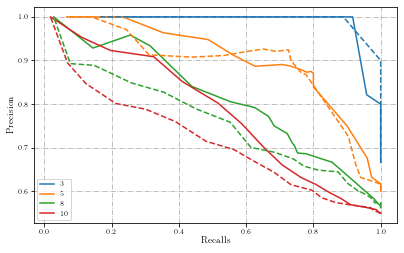

In [84]:
fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=1)['figure.figsize'])

ax = fig.add_subplot(111)
ax.grid(True, which="both", ls="-.")
ax.set_axisbelow(True)
#
for rec_nl,prec_nl, c in zip(recalls_nl, precisions_nl, COLORS):
    im = ax.plot(rec_nl, prec_nl, c=c)
    # im = ax.scatter(rec_nl, prec_nl, c=c)
for rec_lin,prec_lin, c in zip(recalls_lin,precisions_lin, COLORS):
    im = ax.plot(rec_lin, prec_lin, c=c, ls="--")
    # im = ax.scatter(rec_lin, prec_lin, c=c,marker="^")
    # im = ax.plot(thresholds[0,:], prec_nl, c=c)

ax.set_xlabel("Recalls", labelpad=LABELPAD)
ax.set_ylabel("Precision", labelpad=LABELPAD)
plt.legend(DIMS)
ax.tick_params(axis='both', which='major', pad=TICK_PADDING)


plt.savefig("recalls_vs_precisions.svg")

### Monti

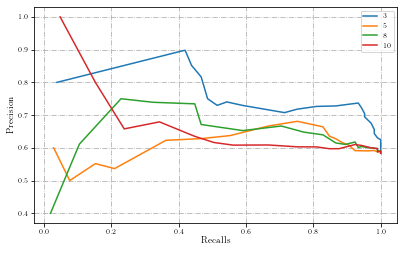

In [94]:
fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=1)['figure.figsize'])

ax = fig.add_subplot(111)
ax.grid(True, which="both", ls="-.")
ax.set_axisbelow(True)
#
for rec,prec, c in zip(recalls_monti, precisions_monti, COLORS):
    im = ax.plot(rec, prec, c=c)
    # im = ax.scatter(rec_nl, prec_nl, c=c)

ax.set_xlabel("Recalls", labelpad=LABELPAD)
ax.set_ylabel("Precision", labelpad=LABELPAD)
plt.legend(DIMS)
ax.tick_params(axis='both', which='major', pad=TICK_PADDING)


plt.savefig("monti_recalls_vs_precisions.svg")

## Hinton diagram

In [121]:
# Source: https://matplotlib.org/3.1.1/gallery/specialty_plots/hinton_demo.html

def hinton(matrix, max_weight=None, ax=None, filename=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))


    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = BLUE if w > 0 else RED
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    if filename is not None:
        plt.savefig(f"{filename}.svg")

In [96]:
from notebooks.analysis import perm2matrix

In [113]:
idx = -1
j_est = torch.from_numpy(est_unmix_jacobians5d_sparse[idx].astype(np.float32))
j_gt = torch.from_numpy(true_unmix_jacobians5d_sparse[idx].astype(np.float32))
j_p= permute_indices5d_sparse[idx]
j_ica = perm2matrix(ica_permute5d_sparse[idx])
j_pm= perm2matrix(j_p)
j_est_corr = j_ica@j_est@j_pm

In [103]:
j_gt[j_gt.abs()<1e-6]=0
j_gt

tensor([[ 0.6245,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.8148,  0.4783,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.7763,  0.8249,  0.0000,  0.0000],
        [-0.2919,  0.0000, -0.4866,  0.6061,  0.0000],
        [ 0.5192,  0.0000,  0.0000, -0.4156,  0.4538]], dtype=torch.float64)

In [115]:
j_est_corr

tensor([[0.6502, 0.0046, 0.0046, 0.0045, 0.0064],
        [0.8523, 0.5019, 0.0076, 0.0076, 0.0072],
        [0.0123, 0.8139, 0.8680, 0.0097, 0.0082],
        [0.3020, 0.0069, 0.5105, 0.6374, 0.0050],
        [1.0000, 0.0082, 0.0091, 0.4306, 0.4713]])

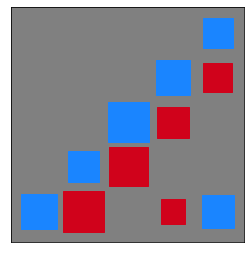

In [123]:
hinton(j_gt, filename="j_gt5d_sparse_hinton")

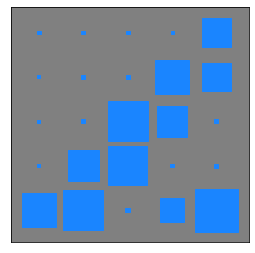

In [122]:
hinton(j_est_corr, filename="j_est_corr_5d_sparse_hinton")